In [13]:
import numpy as np

def tokens(gameType='5555', numBuyers=4, numSellers=4, numTokens=4):
    # Convert game code into upper bounds for token values
    R1 = int(gameType[0])
    R2 = int(gameType[1])
    R3 = int(gameType[2])
    R4 = int(gameType[3])

    # Generate values
    A = np.random.uniform(0, R1, (numBuyers + numSellers, numTokens))  # Baseline randomness in matrix
    B = np.random.uniform(0, R2, (numBuyers + numSellers, 1))  # Randomness accross agents
    C = np.random.uniform(0, R3, (1, numTokens))  # Randomness accross tokens
    D = np.random.uniform(0, R4, (numBuyers, numTokens))  # Randomness accross buyers and sellers
    E = np.zeros((numSellers, numTokens))

    # Collect and normalize between 0-100
    tokenValues = A + B + C + np.r_[D, E]
    tokenValues = ((tokenValues - tokenValues.min()) / (tokenValues.max() - tokenValues.min())) * 100

    # Buyer valuations sort
    redemptionValues = tokenValues[0:numBuyers, :]
    sortedIndices = np.argsort(redemptionValues, axis=1)[:, ::-1]
    redemptionValues = np.take_along_axis(redemptionValues, sortedIndices, axis=1)

    # Seller costs sort
    tokenCosts = tokenValues[numBuyers:(numBuyers + numSellers), :]
    sortedIndicesCosts = np.argsort(tokenCosts, axis=1)
    tokenCosts = np.take_along_axis(tokenCosts, sortedIndicesCosts, axis=1)

    return np.round(redemptionValues,1), np.round(tokenCosts,1)

gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps = '1001', 4, 4, 4, 4, 4, 4

In [2]:
redemptionValues, tokenCosts = tokens(gameTypes, numBuyers, numSellers, numTokens)
print(redemptionValues)
print(tokenCosts)

[[ 83.8  75.6  67.9  40.5]
 [100.   82.4  52.5  28.4]
 [ 40.3  37.2  36.1   3.2]
 [ 82.3  59.9  44.5  31. ]]
[[ 0.  19.5 21.5 27.1]
 [ 6.3 23.5 35.6 39.6]
 [ 2.7  7.  12.  18.6]
 [ 3.   4.4 36.4 53.7]]


In [3]:
def schedules(redemptionValues, tokenCosts):
    prices = np.linspace(0, 100, 100)
    demand = np.zeros((100), dtype='int')
    supply = np.zeros((100), dtype='int')
    for i, p in enumerate(prices):
        demand[i] = np.sum(p <= redemptionValues)
        supply[i] = np.sum(p >= tokenCosts)
    return demand, supply, prices

demand, supply, prices = schedules(redemptionValues,tokenCosts)

In [4]:
def equilibrium(demand,supply,prices):
    peq, qeq = [], np.nan
    for i, p in enumerate(prices):
        if demand[i] == supply[i]:
            peq.append(p)
            qeq = demand[i]
    if len(peq) == 0:
        i = np.argmin(np.abs(demand-supply))
        peq = prices[i] 
        qeq = demand[i]
    return np.round(np.nanmean(peq),1), np.round(qeq,1)
peq, qeq = equilibrium(demand,supply,prices)
print(peq, qeq)

31.3 13


In [5]:
def reservePrices(demand, supply,prices):
    arr = np.zeros_like(demand)
    change = np.where(demand[:-1] != demand[1:])[0]
    arr[change] = 1
    arr[-1] = 1
    buyerReservationPrices = prices[arr==1]
    arr = np.zeros_like(supply)
    change = np.where(supply[:-1] != supply[1:])[0]
    arr[change] = 1
    arr[-1] = 1
    sellerReservationPrices = prices[arr==1]
    return buyerReservationPrices, sellerReservationPrices
buyerReservationPrices, sellerReservationPrices = reservePrices(demand, supply,prices)

In [6]:
redemptionValues-peq, peq-tokenCosts

(array([[ 52.5,  44.3,  36.6,   9.2],
        [ 68.7,  51.1,  21.2,  -2.9],
        [  9. ,   5.9,   4.8, -28.1],
        [ 51. ,  28.6,  13.2,  -0.3]]),
 array([[ 31.3,  11.8,   9.8,   4.2],
        [ 25. ,   7.8,  -4.3,  -8.3],
        [ 28.6,  24.3,  19.3,  12.7],
        [ 28.3,  26.9,  -5.1, -22.4]]))

In [7]:
def surplus(redemptionValues,tokenCosts, peq, qeq):
    buyerSurplus = np.round(np.sum(redemptionValues-peq*np.where(redemptionValues-peq>=0,1,0)),1)
    sellerSurplus = np.round(np.sum(peq-tokenCosts*np.where(peq-tokenCosts>=0,1,0)),1)
    totalSurplus = np.round(buyerSurplus + sellerSurplus,1)
    buyerSurplusFrac = np.round(buyerSurplus/totalSurplus,2)
    sellerSurplusFrac = np.round(sellerSurplus/totalSurplus,2)
    return buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac

buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac = surplus(redemptionValues,tokenCosts, peq, qeq)
print(buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac)

458.7 355.2 813.9 0.56 0.44


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Custom Settings
colors = sns.color_palette("husl", 5)
plot_settings = {
    'figure.figsize': (10, 7),
    'lines.linestyle': '--',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'axes.grid': True,  # Add gridlines
    'font.family': 'serif',  # Use a serif font
    'font.size': 12,
}
plt.rcParams.update(plot_settings)
plt.style.use('seaborn-v0_8-darkgrid')
plt.ioff()

def graphMarket(gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, redemptionValues, tokenCosts, 
                demand, supply, prices, peq, qeq, buyerReservationPrices, sellerReservationPrices, buyerSurplus,
                sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac):
    fig, ax = plt.subplots() 
    ax.plot(demand, prices, label='Demand Curve', color=colors[4], alpha=1.0) 
    ax.plot(supply, prices, label='Supply Curve', color=colors[3], alpha=1.0) 
    ax.scatter(np.unique(demand)[::-1], buyerReservationPrices, label='Buyer Reservation Prices', marker='o', color=colors[4], alpha=0.5)  # Different color
    ax.scatter(np.unique(supply), sellerReservationPrices, label='Seller Reservation Prices', marker='o', color=colors[3], alpha=0.5)  # Different color
    ax.axhline(peq, color=colors[4], alpha = 0.5, label='Eqbm Prices', linestyle='-.')
    ax.axvline(qeq, color=colors[3], alpha = 0.5, label='Eqbm Quantities', linestyle='-.')

    # shade region
    demand_mask = (demand <= qeq) 
    supply_mask = (supply <= qeq)
    ax.fill_between(demand[demand_mask], peq*np.ones(len(demand[demand_mask])), prices[demand_mask], color=colors[4], alpha=0.2, label='Buyer Surplus')
    ax.fill_between(supply[supply_mask], peq*np.ones(len(demand[supply_mask])), prices[supply_mask], color=colors[3], alpha=0.2, label='Seller Surplus')
    ax.text(qeq * 0.1, peq * 1.2, f'{int(buyerSurplusFrac*100)}%', fontsize=10, color='black')
    ax.text(qeq * 0.1, peq * 0.8, f'{int(sellerSurplusFrac*100)}%', fontsize=10, color='black')
    ax.set_xlabel('Quantity')
    ax.set_ylabel('Price')
    
    # Move the legend below the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()
    ax.xaxis.set_label_position('bottom')
    ax.set_yticks(np.arange(min(prices), max(prices) + 1, 5))
    ax.set_xticks(np.arange(0, max(max(demand), max(supply)) + 1, 1))

    # Information box with outline
    info_text = f'Game Type={gameTypes}\nNumber of Buyers = {numBuyers}\nNumber of Sellers = {numSellers}\nNumber of Tokens = {numTokens}'
    info_text2 = f'\nEquilibrium Price = {peq}\nEquilibrium Quantity = {qeq}'
    info_text3 = f'\nTotal Surplus = {totalSurplus}\nBuyer Surplus = {buyerSurplus}\nSeller Surplus = {sellerSurplus}'
    ax.text(qeq*0.75, 75, info_text + info_text2 + info_text3, alpha=0.7, fontsize=9, color='black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
    ax.set_title('Market Equilibrium', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig, ax

# Example usage:
fig, ax = graphMarket(gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps,
                      redemptionValues, tokenCosts, 
                      demand, supply, prices, peq, qeq, 
                      buyerReservationPrices, sellerReservationPrices, 
                      buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac)

plt.close()

In [10]:
def roundSetup(gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps):
    metadata = []
    redemptionValues, tokenCosts = tokens(gameTypes, numBuyers, numSellers, numTokens)
    demand, supply, prices = schedules(redemptionValues,tokenCosts)
    peq, qeq = equilibrium(demand,supply,prices)
    buyerReservationPrices, sellerReservationPrices = reservePrices(demand, supply,prices)
    buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac = surplus(redemptionValues,tokenCosts, peq, qeq)
    metadata += [redemptionValues, tokenCosts, demand, supply, prices, peq, qeq]
    metadata += [buyerReservationPrices, sellerReservationPrices, buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac]
    return metadata

roundData = roundSetup(gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps)

### Test

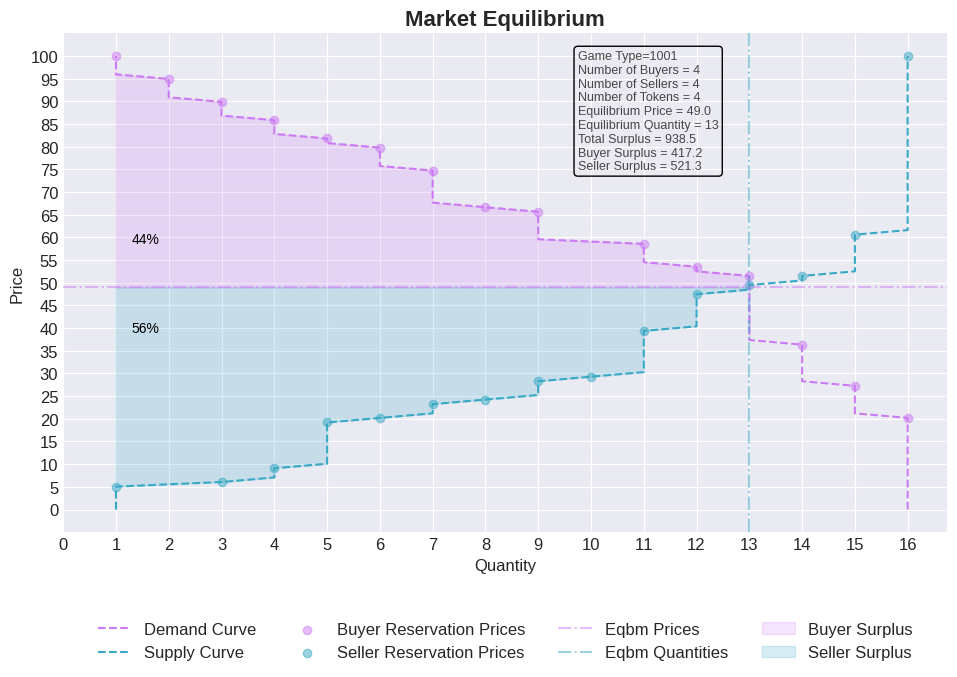

In [12]:
from setup import *
gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps = '1001', 4, 4, 4, 4, 4, 4
gameData = gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps
roundData = roundSetup(*gameData)
fig, ax = graphMarket(*gameData,*roundData)
plt.show()